# Intro

Name:  

    Cair_AirSHARP2024_data

Purpose:  

    Create initial data for the Cair on AirSHARP on board the Twin Otter
    incorporates the Navmet data

Input:

    none at command line

Output:

    dict and plots 

Keywords:

    none

Dependencies:

    - numpy
    - Pyephem
    - pandas

Needed Files:

  - Cair raw calibrated comma delimited files (URC)

Modification History:

    Written: Samuel LeBlanc, Santa Cruz, 2024-10-16
    Modified: 

# Load the required modules and prepare the paths

In [1]:
import matplotlib 
#matplotlib.rc_file('C:\\Users\\sleblan2\\Research\\python_codes\\file.rc')
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import os

In [91]:
import map_utils as mu
import plotting_utils as pu
import matplotlib.colors as colors
from load_utils import mat2py_time, toutc, load_ict
from Sp_parameters import smooth
from linfit import linfit
from path_utils import getpath
from scipy.interpolate import interp1d

In [3]:
import pandas as pd

In [4]:
fp = getpath('AirSHARP2024')#'C:/Userds/sleblan2/Research/ORACLES/'
fp_raw = getpath('AirSHARP2024_raw')
fp

Return path named:  AirSHARP2024 /data/sunsat/AirSHARP_2024/
Return path named:  AirSHARP2024_raw /data/sunsat/AirSHARP_2024/data_raw/


'/data/sunsat/AirSHARP_2024/'

In [5]:
vr='RA'

# load the files

In [6]:
folders = ['CAIR_20241007_EMI_flt00', 'CAIR_20241008_RF01', 'CAIR_20241012_RF02']
folders.sort()

In [66]:
data = {}
for f in folders:
    files_all = os.listdir(fp_raw+f+os.sep)
    files = [d for d in files_all if d.endswith('.csv') and d.find('Log')<0 and d.find('Aux')<0] # only select data csv files, not Aux or Log
    files.sort()
    print('In folder: {f} with #{n} of data files'.format(f=f,n=len(files)))
    da = pd.concat((pd.read_csv(fp_raw+f+os.sep+g, sep=',', encoding='ISO-8859-1', index_col='DateTimeUTC') for g in files))#, ignore_index=True) #loop through and read all files
    da.index = pd.to_datetime(da.index)
    get_units = lambda x: x[x.find(' '):].strip()
    set_name = lambda x: x.split(' ')[0].strip()
    data['units'] = [get_units(c) for c in da.columns]
    data['variables'] = [set_name(c) for c in da.columns]
    data[f] = da.rename(set_name,axis='columns')

In folder: CAIR_20241007_EMI_flt00 with #67 of data files


/tmp/ipykernel_1899624/2028689646.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  da.index = pd.to_datetime(da.index)


In folder: CAIR_20241008_RF01 with #228 of data files


/tmp/ipykernel_1899624/2028689646.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  da.index = pd.to_datetime(da.index)


In folder: CAIR_20241012_RF02 with #119 of data files


/tmp/ipykernel_1899624/2028689646.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  da.index = pd.to_datetime(da.index)


In [8]:
## load the navmet

In [79]:
for f in folders:
    files_all = os.listdir(fp_raw+f+os.sep)
    files = [d for d in files_all if d.endswith('.ict')]
    data[f+'_NAV']=pd.DataFrame(load_ict(fp_raw+f+os.sep+files[0]))
    daystr = f.split('_')[1]
    data[f+'_NAV'].index = pd.to_timedelta(data[f+'_NAV']['Time_Start'],unit='s')+pd.to_datetime(daystr,format='%Y%m%d')

('Time_Start', 'Latitude', 'Longitude', 'GPS_Altitude', 'Pressure_Altitude', 'Radar_Altitude', 'Pitch_Angle', 'Roll_Angle', 'True_Heading', 'True_Air_Speed', 'East_Vel_Aircraft', 'North_Vel_Aircraft', 'Up_Vel_Aircraft', 'Press_Ambient', 'Temp_Ambient', 'Temp_DewPoint', 'Relative_Humidity_Ambient', 'Potential_Temp', 'Equivalent_Potential_Temp', 'Virtual_Potential_Temp', 'Virtual_Temp', 'Wind_Speed', 'Wind_Direction', 'Vert_WindSpeed', 'H2OMR', 'SPHum', 'IRT_Nad')
('Time_Start', 'Latitude', 'Longitude', 'GPS_Altitude', 'Pressure_Altitude', 'Radar_Altitude', 'Pitch_Angle', 'Roll_Angle', 'True_Heading', 'True_Air_Speed', 'East_Vel_Aircraft', 'North_Vel_Aircraft', 'Up_Vel_Aircraft', 'Press_Ambient', 'Temp_Ambient', 'Temp_DewPoint', 'Relative_Humidity_Ambient', 'Potential_Temp', 'Equivalent_Potential_Temp', 'Virtual_Potential_Temp', 'Virtual_Temp', 'Wind_Speed', 'Wind_Direction', 'Vert_WindSpeed', 'H2OMR', 'SPHum', 'IRT_Nad')
('Time_Start', 'Latitude', 'Longitude', 'GPS_Altitude', 'Pressure_

In [80]:
data.keys()

dict_keys(['units', 'variables', 'CAIR_20241007_EMI_flt00', 'CAIR_20241008_RF01', 'CAIR_20241012_RF02', 'CAIR_20241007_EMI_flt00_NAV', 'CAIR_20241008_RF01_NAV', 'CAIR_20241012_RF02_NAV'])

# Interpolate navmet data to CAIR timestamps

In [90]:
data[f+'_NAV'].keys()

Index(['Time_Start', 'Latitude', 'Longitude', 'GPS_Altitude',
       'Pressure_Altitude', 'Radar_Altitude', 'Pitch_Angle', 'Roll_Angle',
       'True_Heading', 'True_Air_Speed', 'East_Vel_Aircraft',
       'North_Vel_Aircraft', 'Up_Vel_Aircraft', 'Press_Ambient',
       'Temp_Ambient', 'Temp_DewPoint', 'Relative_Humidity_Ambient',
       'Potential_Temp', 'Equivalent_Potential_Temp', 'Virtual_Potential_Temp',
       'Virtual_Temp', 'Wind_Speed', 'Wind_Direction', 'Vert_WindSpeed',
       'H2OMR', 'SPHum', 'IRT_Nad'],
      dtype='object')

In [105]:
def inter(xold,yold,xnew):
    igood = np.isfinite(xold) & np.isfinite(yold)
    fx = interp1d(xold[igood],yold[igood],fill_value="extrapolate")
    return fx(xnew)

In [110]:
for f in folders:
    for k in data[f+'_NAV']:
        if k == 'Time_Start': 
            continue
        data[f][k] = inter(pd.to_numeric(data[f+'_NAV'].index),data[f+'_NAV'][k],pd.to_numeric(data[f].index))
    

## Add the solar geometry calculations

In [146]:
for f in folders:
    sza,azi = mu.get_sza_azi(data[f]['Latitude'],data[f]['Longitude'],data[f].index)
    data[f]['sza'] = sza
    data[f]['azi'] = azi
    data[f]['azi_opp'] = (np.array(azi)+180)%360.0

## Make filters

In [157]:
for f in folders:
    flt = (np.abs(data[f]['Pitch_Angle'])<2.5) & (data[f]['GPS_Altitude']<50.0) & \
       (((data[f]['True_Heading']>data[f]['azi']-5.0)&(data[f]['True_Heading']<data[f]['azi']+5.0)) |\
        ((data[f]['True_Heading']>data[f]['azi_opp']-5.0)&(data[f]['True_Heading']<data[f]['azi_opp']+5.0)))
    data[f]['filter'] = flt

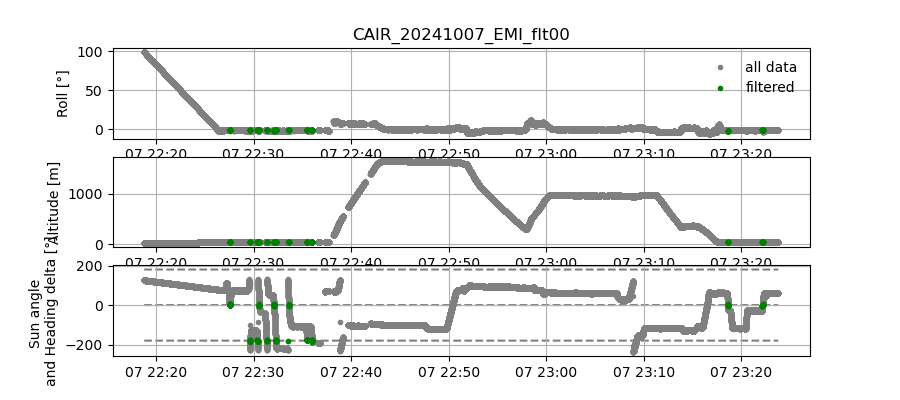

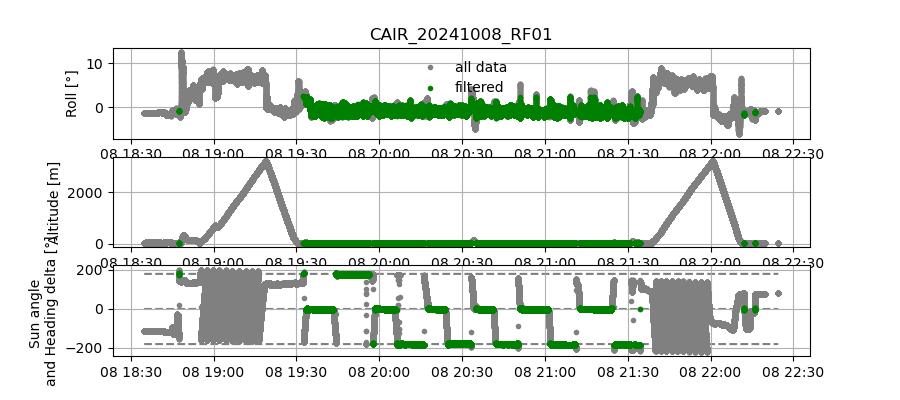

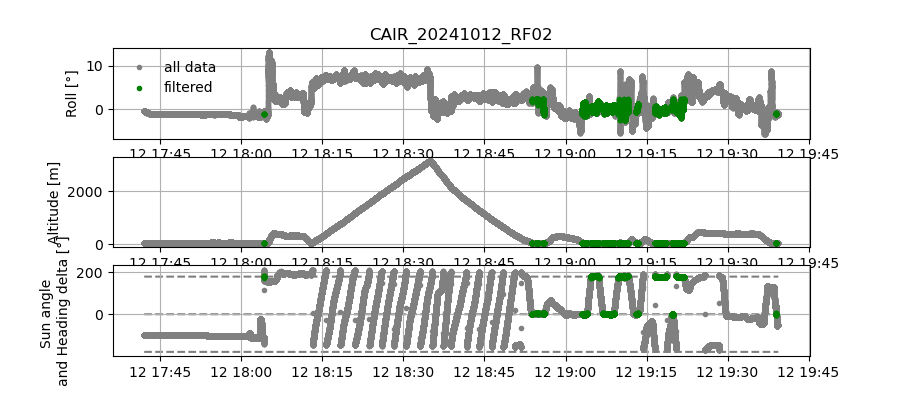

In [182]:
for f in folders:
    flt = data[f]['filter']
    fig, ax = plt.subplots(3,figsize=(9,4))
    ax[0].plot(data[f].index,data[f]['Pitch_Angle'],'.',color='grey',label='all data')
    ax[0].plot(data[f].index[flt],data[f]['Pitch_Angle'][flt],'.',color='green',label='filtered')
    ax[0].set_ylabel('Pitch [°]')
    ax[0].set_title(f)
    ax[0].grid()
    ax[0].legend(frameon=False)
    
    ax[1].plot(data[f].index,data[f]['GPS_Altitude'],'.',color='grey')
    ax[1].plot(data[f].index[flt],data[f]['GPS_Altitude'][flt],'.',color='green')
    ax[1].set_ylabel('Altitude [m]')
    ax[1].grid()
    
    ax[2].plot(data[f].index,(data[f]['True_Heading']-data[f]['azi']),'.',color='grey')
    ax[2].plot(data[f].index[flt],(data[f]['True_Heading']-data[f]['azi'])[flt],'.',color='green')
    ax[2].plot(data[f].index,data[f]['azi']*0.0,'--k',alpha=0.5,zorder=-1)
    ax[2].plot(data[f].index,data[f]['azi']*0.0+180,'--k',alpha=0.5,zorder=-1)
    ax[2].plot(data[f].index,data[f]['azi']*0.0-180,'--k',alpha=0.5,zorder=-1)
    ax[2].grid()
    ax[2].set_ylabel('Sun angle \nand Heading delta [°]')

# Plot the data

In [50]:
Es_names = [v for v in data['variables'] if v.startswith('Es') and len(v)==5]
Li_names = [v for v in data['variables'] if v.startswith('Li') and len(v)==5]
Lt_names = [v for v in data['variables'] if v.startswith('Lt') and len(v)==5]

In [56]:
Esi = [i for i,v in enumerate(data['variables']) if Es_names[0]==v ]
Es_unit = data['units'][Esi[0]]
Lii = [i for i,v in enumerate(data['variables']) if Li_names[0]==v ]
Li_unit = data['units'][Lii[0]]
Lti = [i for i,v in enumerate(data['variables']) if Lt_names[0]==v ]
Lt_unit = data['units'][Lti[0]]

## Roll and Pitch

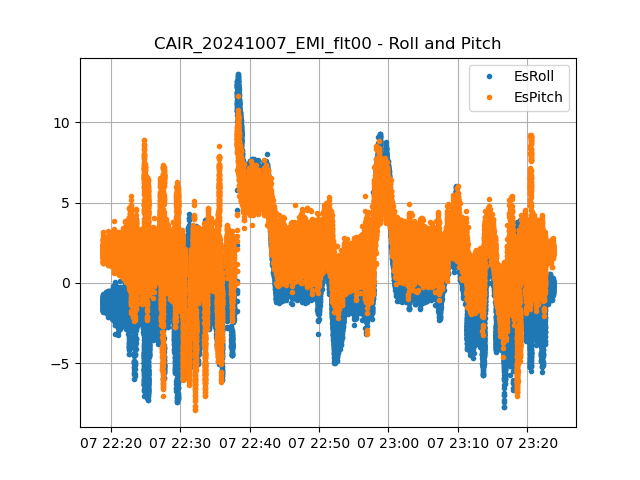

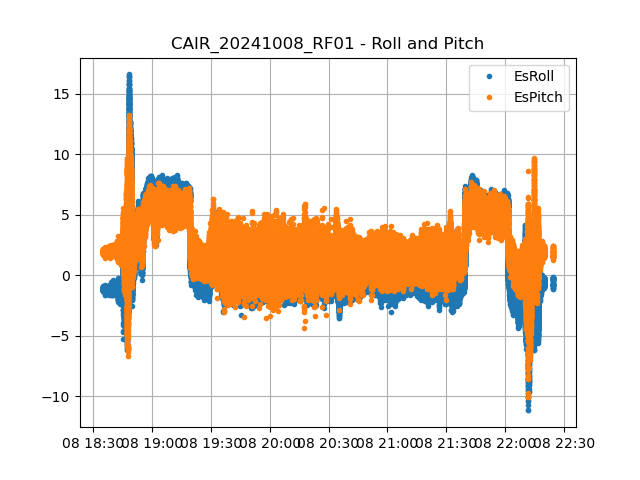

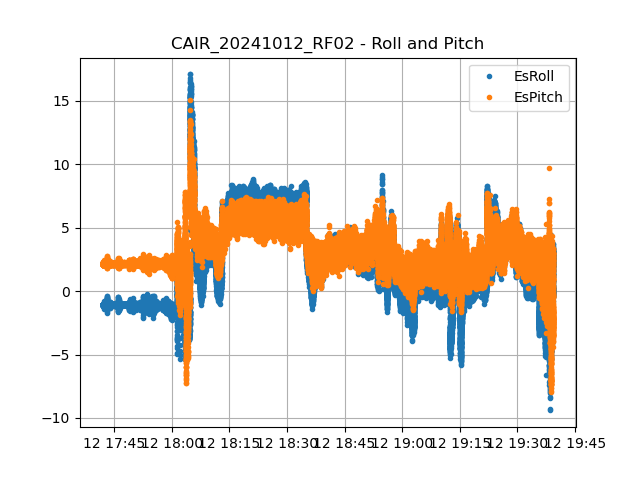

In [184]:
for f in folders:
    fig,ax = plt.subplots(1)
    plt.plot(data[f].index,data[f]['EsRoll'],'.',label='EsRoll')
    p = plt.plot(data[f].index,data[f]['EsPitch'],'.',label='EsPitch')
    plt.legend(frameon=True)
    plt.title(f+' - Roll and Pitch')
    plt.grid()
    

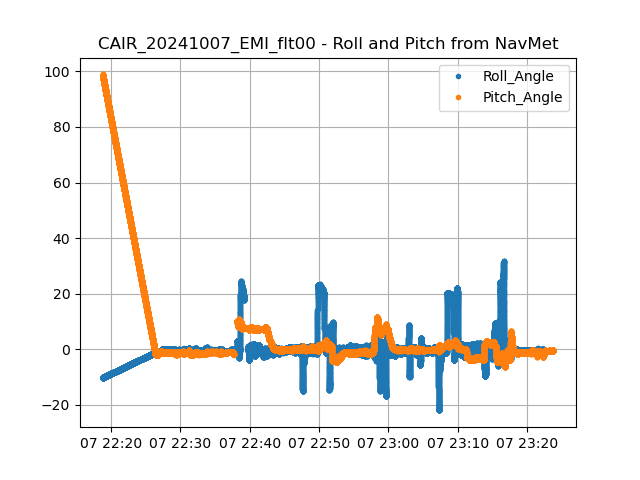

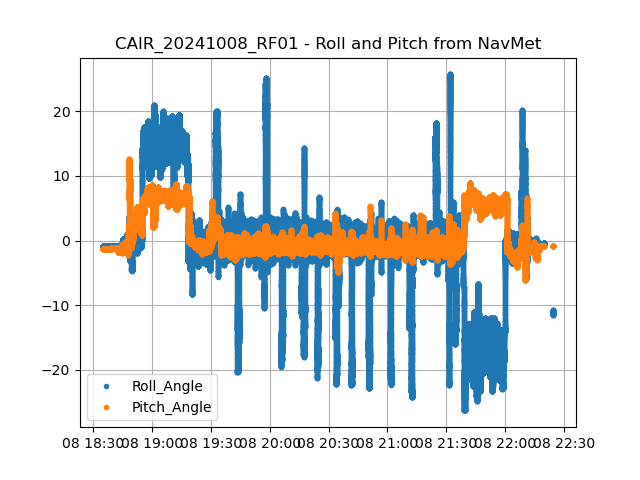

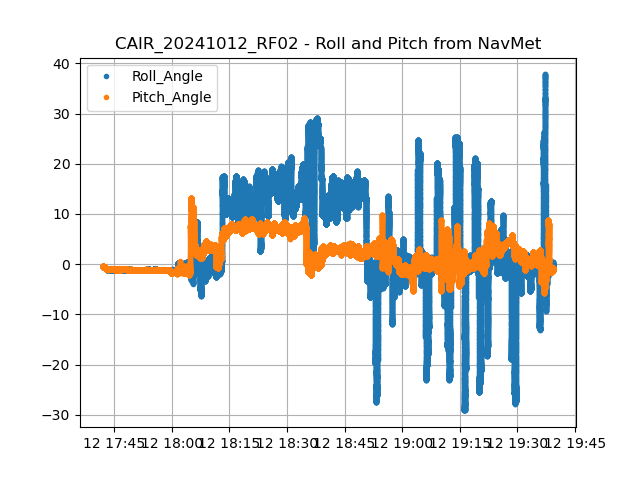

In [112]:
for f in folders:
    fig,ax = plt.subplots(1)
    plt.plot(data[f].index,data[f]['Roll_Angle'],'.',label='Roll_Angle')
    plt.plot(data[f].index,data[f]['Pitch_Angle'],'.',label='Pitch_Angle')
    plt.legend(frameon=True)
    plt.title(f+' - Roll and Pitch from NavMet')
    plt.grid()
    

## Plot the altitude

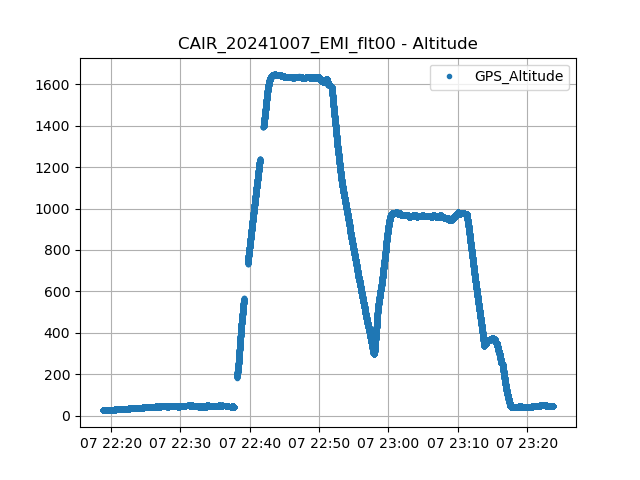

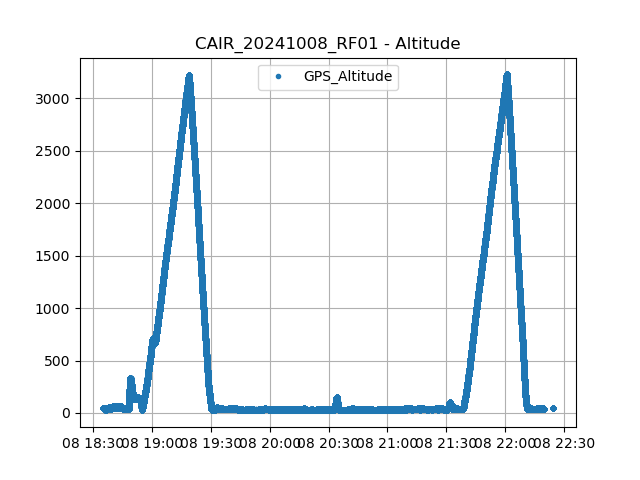

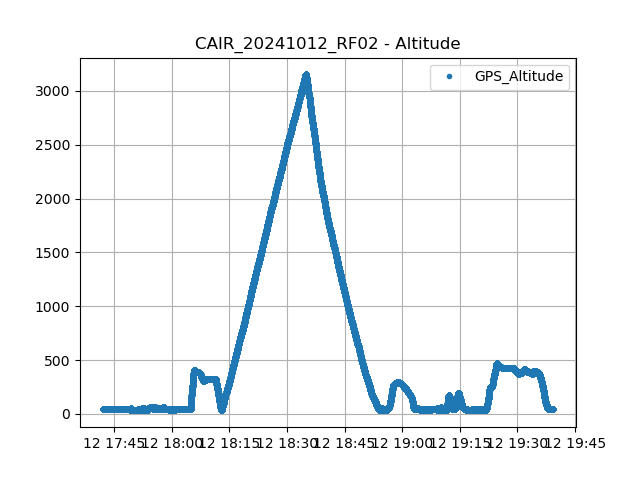

In [113]:
for f in folders:
    fig,ax = plt.subplots(1)
    plt.plot(data[f].index,data[f]['GPS_Altitude'],'.',label='GPS_Altitude')
    plt.legend(frameon=True)
    plt.title(f+' - Altitude')
    plt.grid()

## Plot the lat& lon path

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


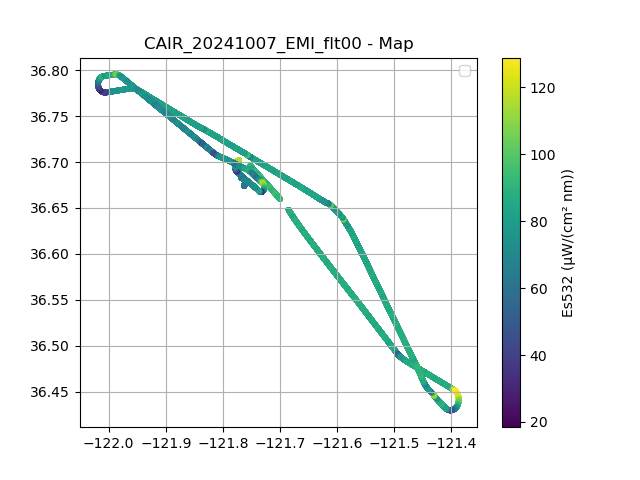

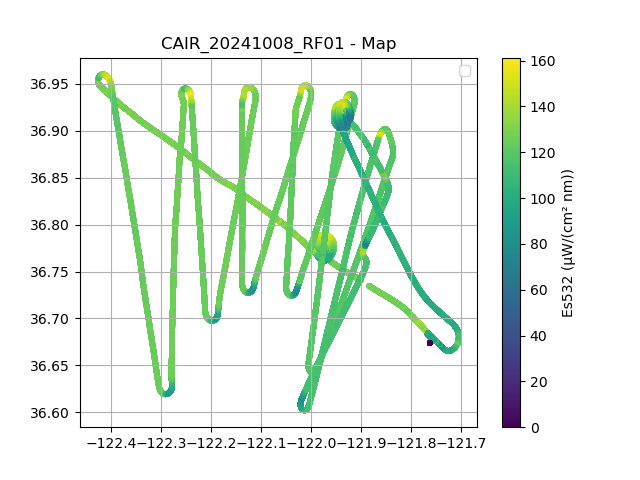

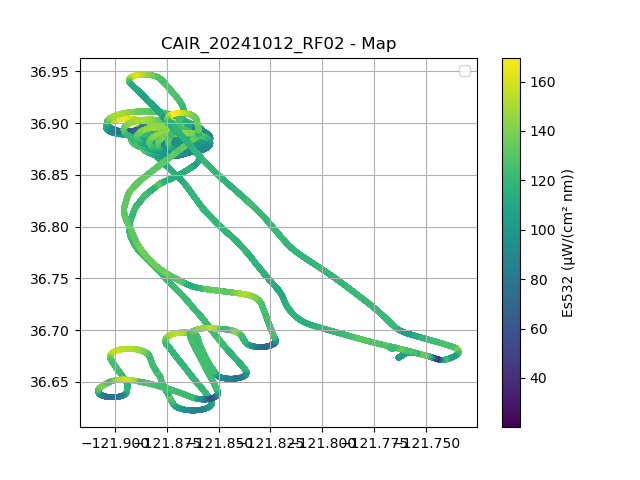

In [120]:
for f in folders:
    fig,ax = plt.subplots(1)
    plt.scatter(data[f]['Longitude'],data[f]['Latitude'],marker='.',c=data[f]['Es532'])
    plt.colorbar(label='Es532 '+Es_unit)
    plt.legend(frameon=True)
    plt.title(f+' - Map')
    plt.grid()

## plot the Es

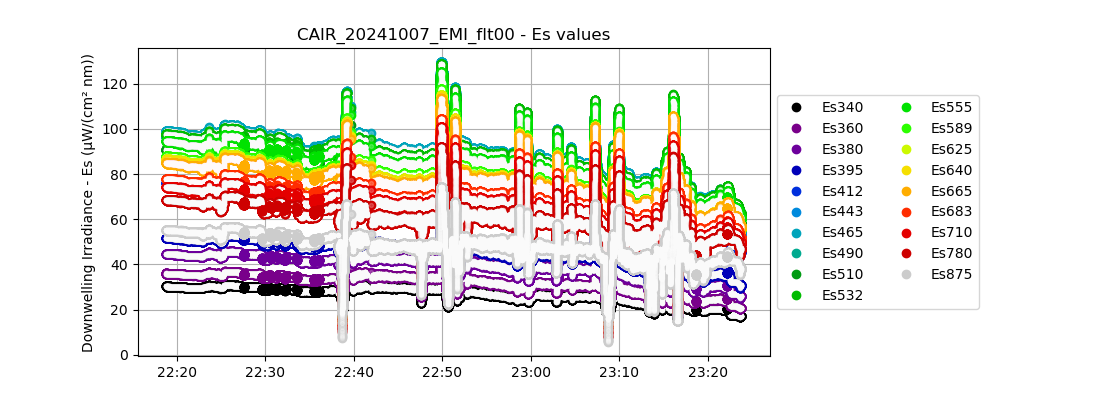

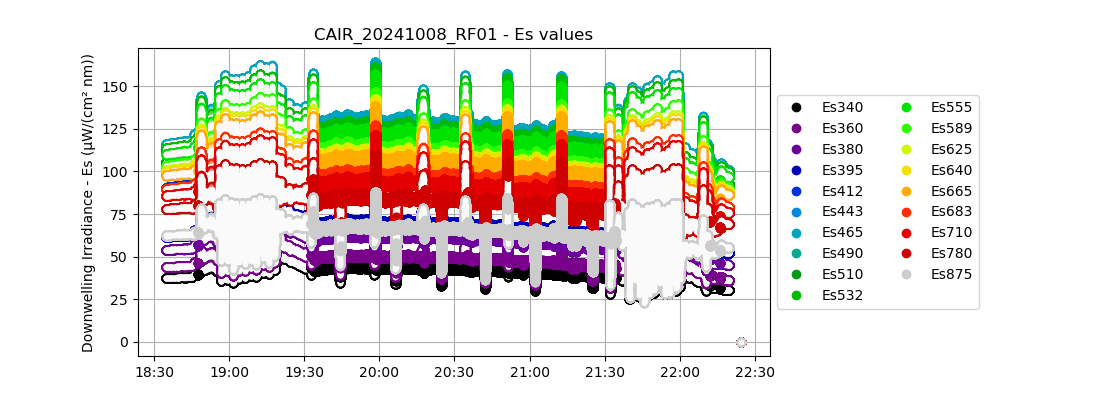

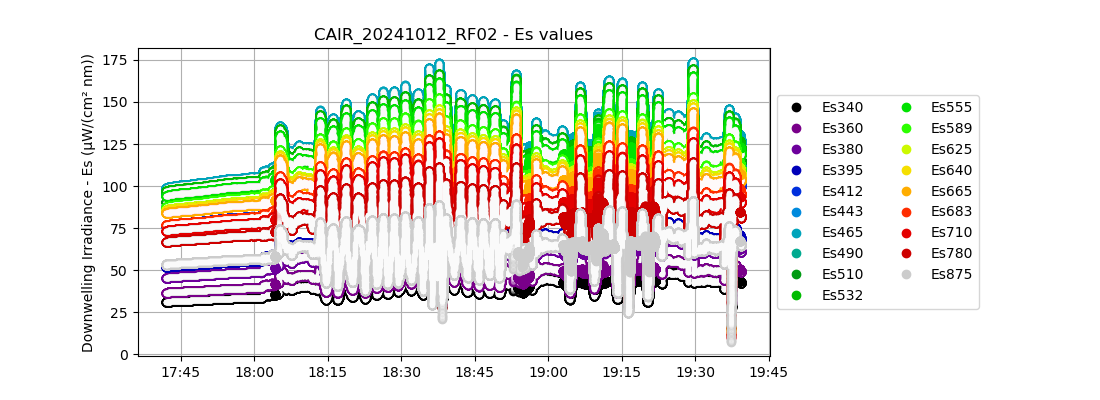

In [211]:
for f in folders:
    fig,ax = plt.subplots(1,figsize=(11,4))
    flt = data[f]['filter']
    ax.set_prop_cycle('color', [plt.get_cmap('nipy_spectral')(k) for k in np.linspace(0,1,len(Es_names))])
    for v in Es_names:
        p = plt.plot(data[f].index,data[f][v],'o')
        plt.plot(data[f].index,data[f][v],'o',color='white',alpha=0.2,markersize=2.9)
        plt.plot(data[f].index[flt],data[f][v][flt],'o',label=v,color=p[0].get_color())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
    plt.legend(frameon=True,ncols=2,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f+' - Es values')
    plt.ylabel('Downwelling Irradiance - Es '+Es_unit)
    plt.grid()
    plt.subplots_adjust(right=0.7)

## Plot the Li

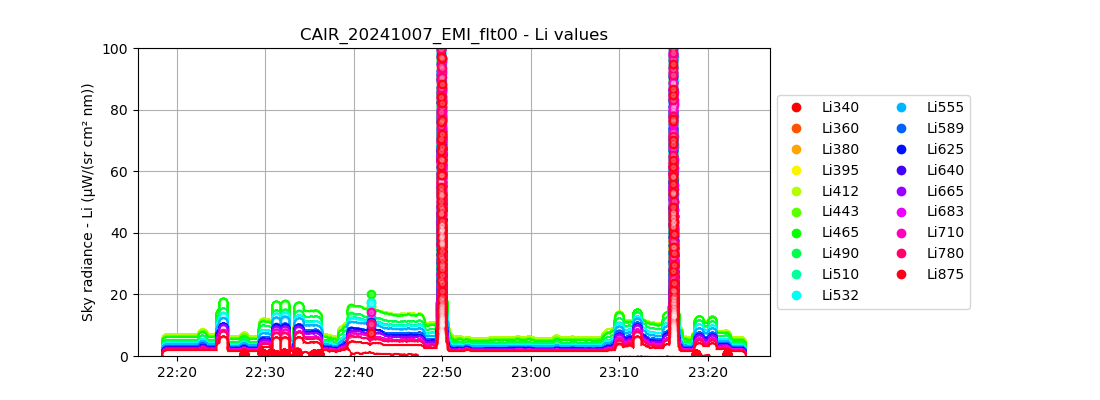

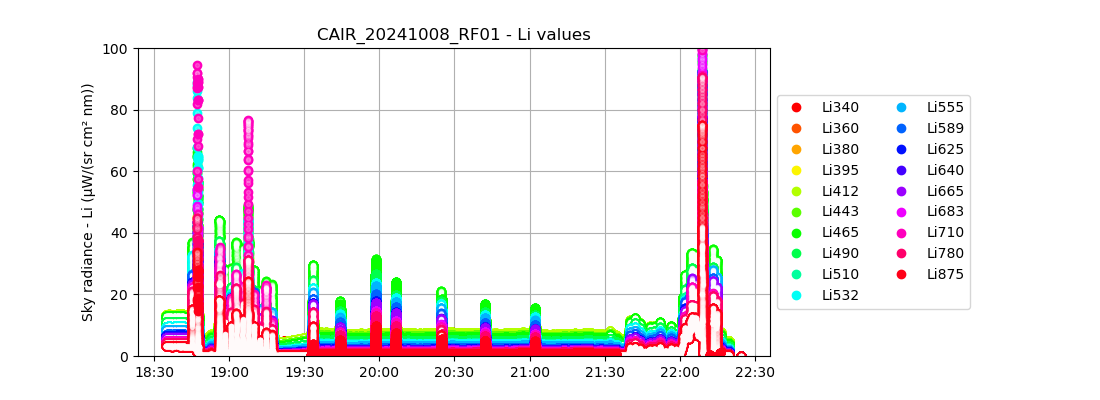

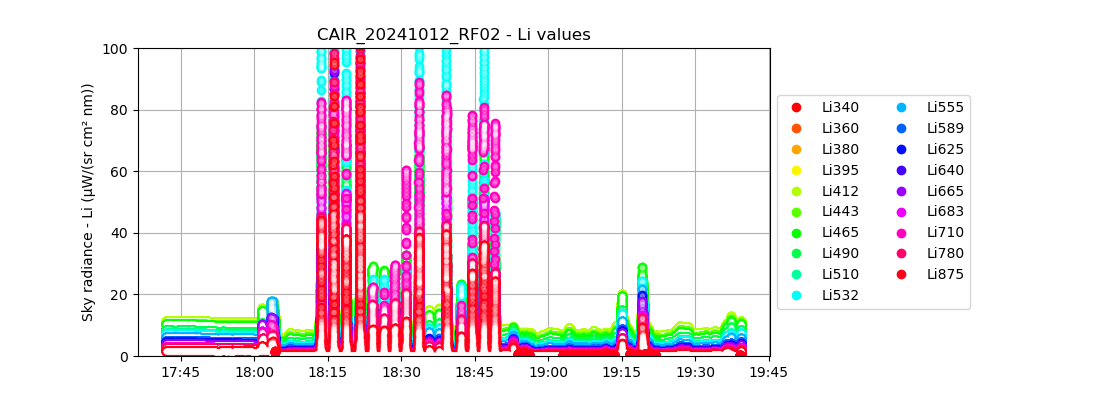

In [212]:
for f in folders:
    fig,ax = plt.subplots(1,figsize=(11,4))
    ax.set_prop_cycle('color', [plt.get_cmap('hsv')(k) for k in np.linspace(0,1,len(Li_names))])
    flt = data[f]['filter']
    for v in Li_names:
        p = plt.plot(data[f].index,data[f][v],'o')
        plt.plot(data[f].index,data[f][v],'o',color='white',alpha=0.2,markersize=2.9)
        plt.plot(data[f].index[flt],data[f][v][flt],'o',label=v,color=p[0].get_color())
    plt.legend(frameon=True,ncols=2,loc='center left', bbox_to_anchor=(1, 0.5))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
    plt.title(f+' - Li values')
    plt.ylabel('Sky radiance - Li '+Li_unit)
    plt.grid()
    plt.subplots_adjust(right=0.7)
    plt.ylim([0,100])

## Plot the Lt values

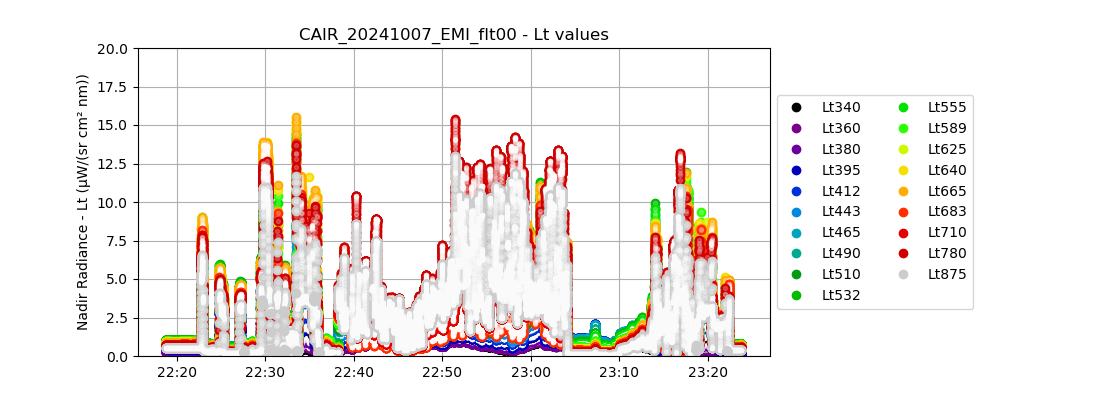

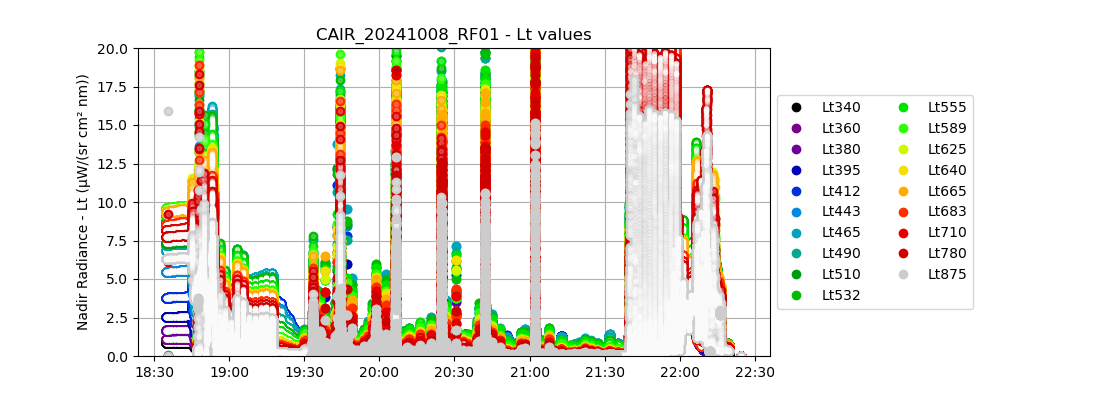

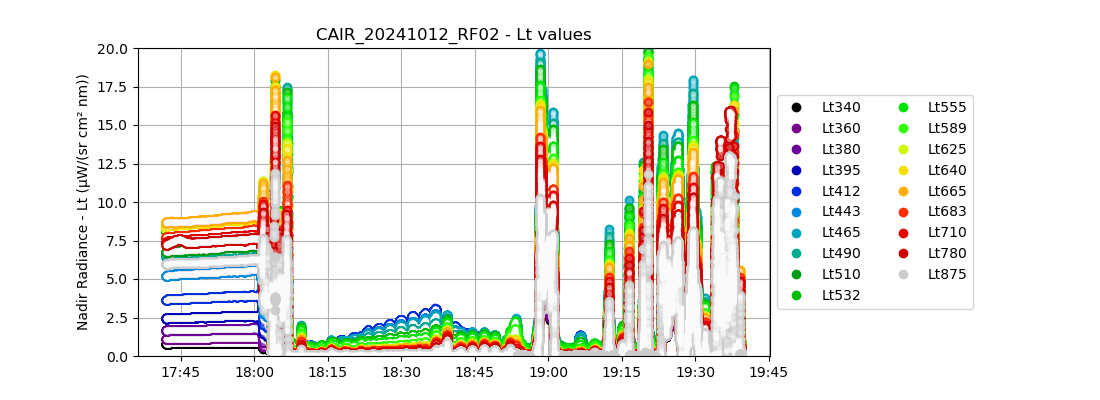

In [213]:
for f in folders:
    fig,ax = plt.subplots(1,figsize=(11,4))
    ax.set_prop_cycle('color', [plt.get_cmap('nipy_spectral')(k) for k in np.linspace(0,1,len(Lt_names))])
    flt = data[f]['filter']
    for v in Lt_names:
        p = plt.plot(data[f].index,data[f][v],'o')
        plt.plot(data[f].index,data[f][v],'o',color='white',alpha=0.2,markersize=2.9)
        plt.plot(data[f].index[flt],data[f][v][flt],'o',label=v,color=p[0].get_color())
    plt.legend(frameon=True,ncols=2,loc='center left', bbox_to_anchor=(1, 0.5))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
    plt.title(f+' - Lt values')
    plt.ylabel('Nadir Radiance - Lt '+Lt_unit)
    plt.grid()
    plt.subplots_adjust(right=0.7)
    plt.ylim([0,20])

# Convert the values to water leaving radiance

## Theory for getting the water-leaving-radiance

From Hooker and Houskeeper, An Above- and In-Water Radiometric Framework for H-Q2O, :
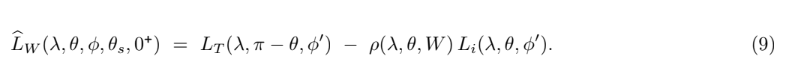
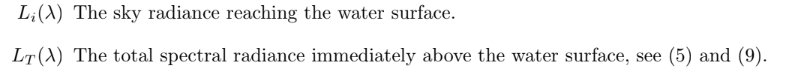
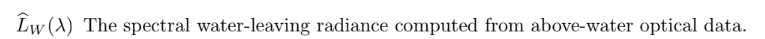

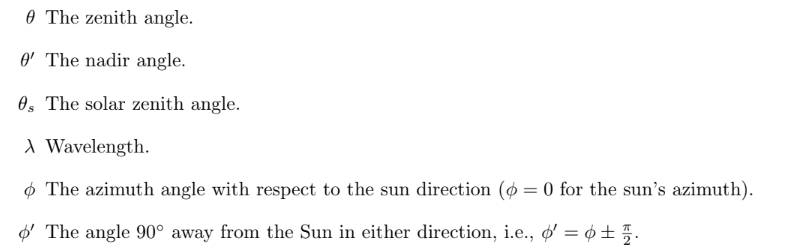

From Mobley, table calculations of phi / water reflectance - based on wind, solar angle directions. 

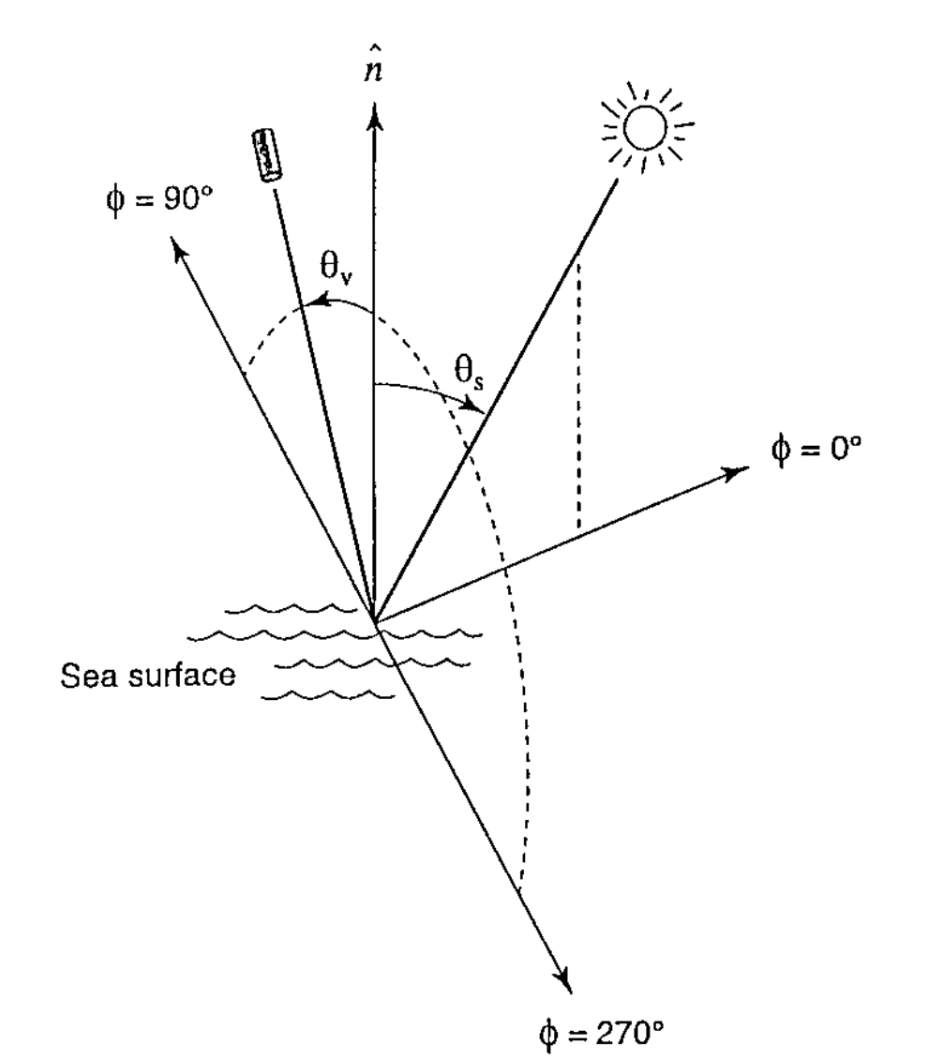

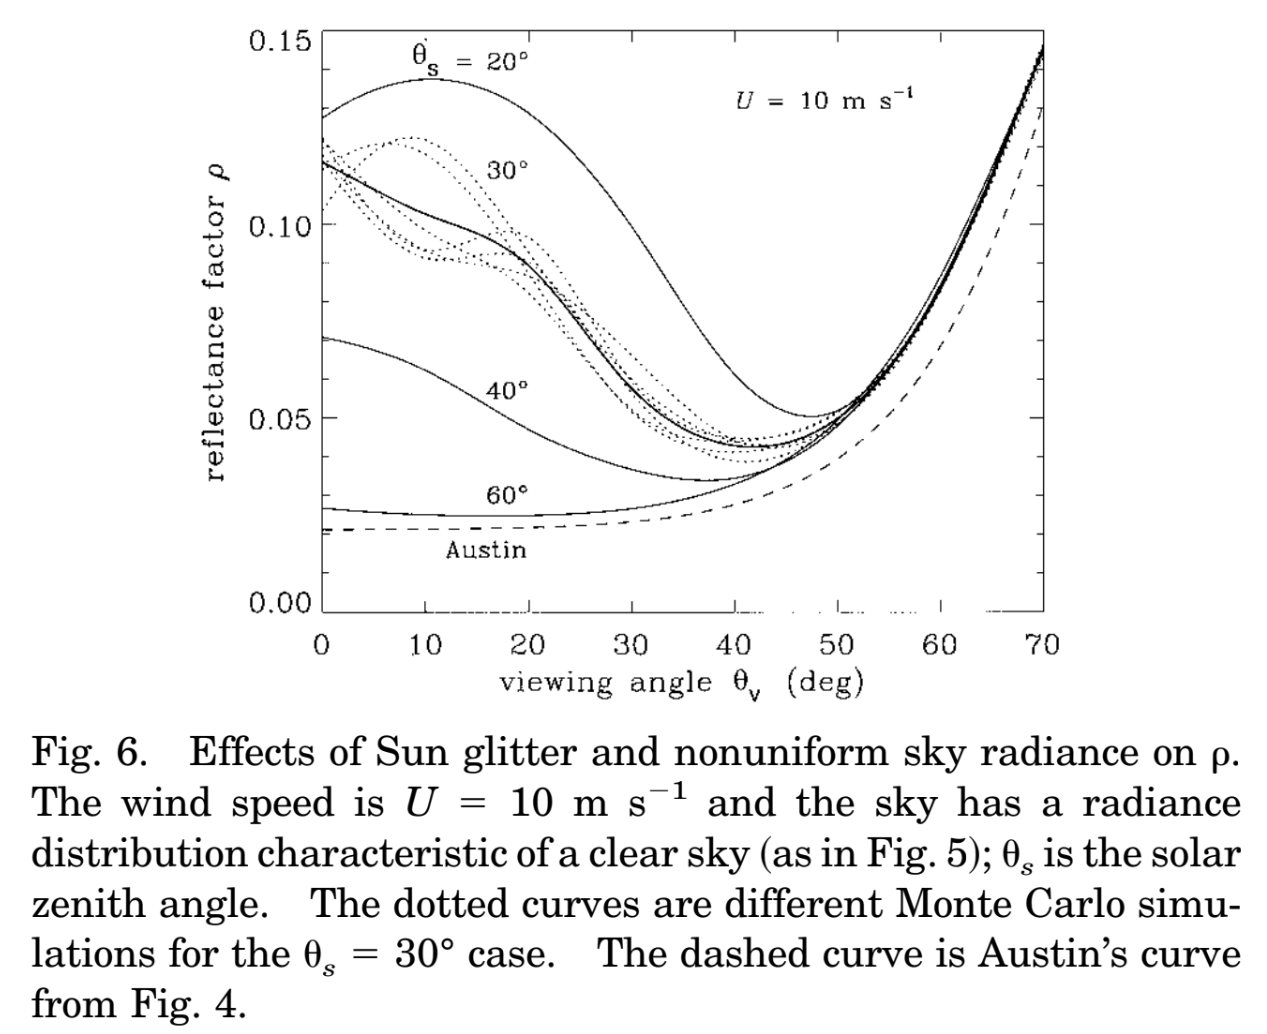

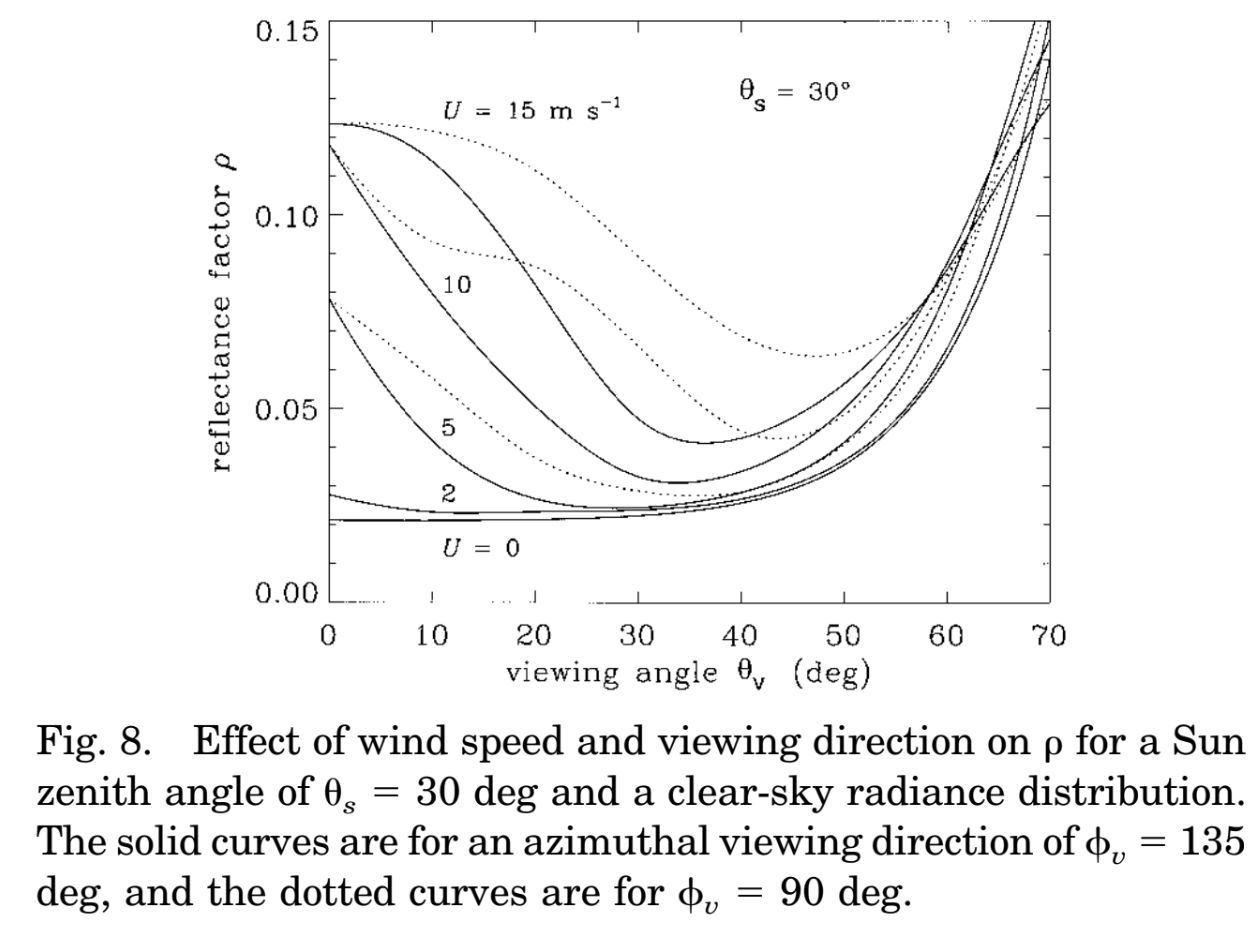

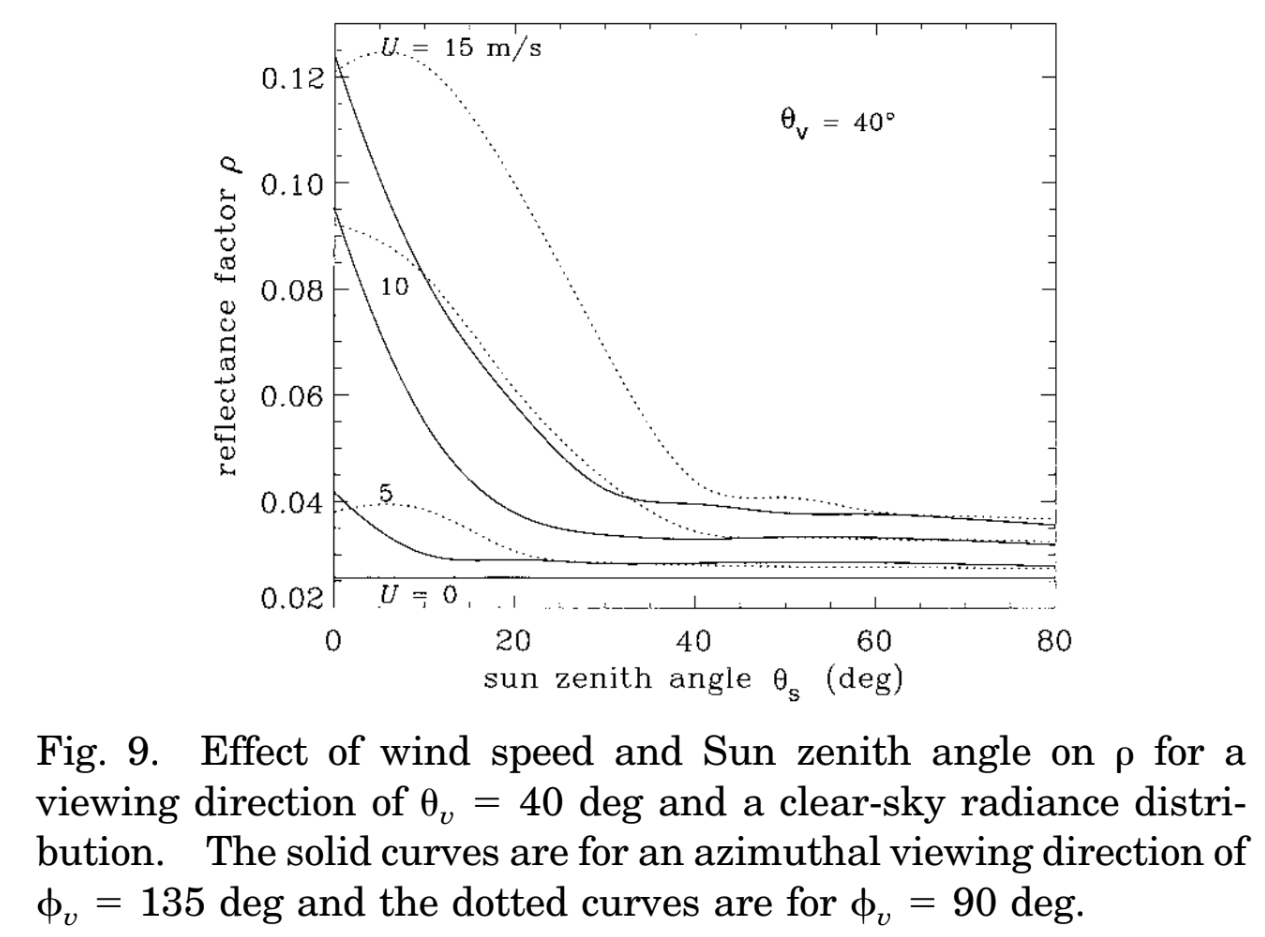

## Get the look up table from the figure 9

In [215]:
sza_U0 = [6.603134675518419, 12.993269641911784, 19.831838553515976, 29.865464684556684, 39.955151473598846, 50.044838262641, 59.910313210957824, 69.83183855351595]
rho_U0 = [0.0260992915322978, 0.02600473466130604, 0.02600473466130604, 0.02600473466130604, 0.02600473466130604, 0.025910169132845773, 0.02600473466130604, 0.025910169132845773]

In [216]:
sza_U5 = [5.650216390855496, 12.769057801186458, 20.224211840725335, 29.921525342558134, 39.618828580630776, 49.82062642191566, 59.966363605199135, 69.66367710703193]
rho_U5 = [0.03990544312900824, 0.03659574486505252, 0.030827429435814964, 0.028841613940428938, 0.028179672556144092, 0.028085107027683825, 0.027990550156692065, 0.027612296700319512]

In [217]:
sza_U10 = [5.538110470492828, 12.488785302459677, 20.448423681450663, 29.136768504379244, 39.7869900271148, 49.70851536967293, 59.798202158715085, 69.88788894775725]
rho_U10 = [0.08851064000173581, 0.07763593754134279, 0.060330973938693105, 0.04557920168725404, 0.03489361729757878, 0.03328605525856531, 0.033569743186477596, 0.033191489730105043]

In [218]:
sza_U15 = [5.5941659966142065, 10.470847944651249, 14.899095947477477, 32.107624146850604, 36.14349886246746, 49.87667681615696, 60.02242426320058, 70.11211105224274, 2.1188260146907396, 19.27129355606241, 23.587440770406058, 28.4641227184431, 40.403585418809655, 44.32734908218377]
rho_U15 = [0.12463357021068977, 0.12160756636774772, 0.11356973885774332, 0.0624113463050709, 0.05125296024549983, 0.04113475171164916, 0.03829787243252626, 0.037541374177249655, 0.12293144264321601, 0.10193853381333945, 0.08888888912937412, 0.07356974102211047, 0.043498820663407746, 0.040945629312197133]

In [221]:
fx_U0 = interp1d(sza_U0,rho_U0,kind='cubic')
fx_U5 = interp1d(sza_U5,rho_U5,kind='cubic')
fx_U10 = interp1d(sza_U10,rho_U10,kind='cubic')
fx_U15 = interp1d(sza_U15,rho_U15,kind='cubic')

In [245]:
def get_rho(windspeed,sza):
    fx = np.array([fx_U0(sza),fx_U5(sza),fx_U10(sza),fx_U15(sza)])
    fx_rho = [interp1d([0.0,5.0,10.0,15.0],[fx_U0(sz),fx_U5(sz),fx_U10(sz),fx_U15(sz)],kind='linear',fill_value="extrapolate")(windspeed[i]) for i,sz in enumerate(sza)]
    return fx_rho

In [248]:
for f in folders:
    print(f)
    rho = get_rho(data[f]['Wind_Speed'],data[f]['sza'])
    data[f]['rho'] = rho

CAIR_20241007_EMI_flt00
CAIR_20241008_RF01
CAIR_20241012_RF02


## Calculate the water leaving radiance

In [249]:
data[f].keys()

Index(['DateTime', 'Master_FrameNumber', 'Master_Time', 'EsRoll', 'EsPitch',
       'Es340', 'Es360', 'Es380', 'Es395', 'Es412', 'Es443', 'Es465', 'Es490',
       'Es510', 'Es532', 'Es555', 'Es589', 'Es625', 'Es640', 'Es665', 'Es683',
       'Es710', 'Es780', 'Es875', 'Li340', 'Li360', 'Li380', 'Li395', 'Li412',
       'Li443', 'Li465', 'Li490', 'Li510', 'Li532', 'Li555', 'Li589', 'Li625',
       'Li640', 'Li665', 'Li683', 'Li710', 'Li780', 'Li875', 'Lt340', 'Lt360',
       'Lt380', 'Lt395', 'Lt412', 'Lt443', 'Lt465', 'Lt490', 'Lt510', 'Lt532',
       'Lt555', 'Lt589', 'Lt625', 'Lt640', 'Lt665', 'Lt683', 'Lt710', 'Lt780',
       'Lt875', 'Latitude', 'Longitude', 'GPS_Altitude', 'Pressure_Altitude',
       'Radar_Altitude', 'Pitch_Angle', 'Roll_Angle', 'True_Heading',
       'True_Air_Speed', 'East_Vel_Aircraft', 'North_Vel_Aircraft',
       'Up_Vel_Aircraft', 'Press_Ambient', 'Temp_Ambient', 'Temp_DewPoint',
       'Relative_Humidity_Ambient', 'Potential_Temp',
       'Equivalent_Poten

In [262]:
wvls = ['340','360','380','395','412','443','465','490','510','532','555','589','625','640','665','683','710','780','875']

In [263]:
#Lw = Lt - rho*Li
for f in folders:
    for w in wvls:
        data[f]['Lw'+w] = data[f]['Lt'+w] - data[f]['rho']*data[f]['Li'+w]

### plot the water leaving radiances

In [264]:
Lw_names = [v.replace('t','w') for v in data['variables'] if v.startswith('Lt') and len(v)==5]

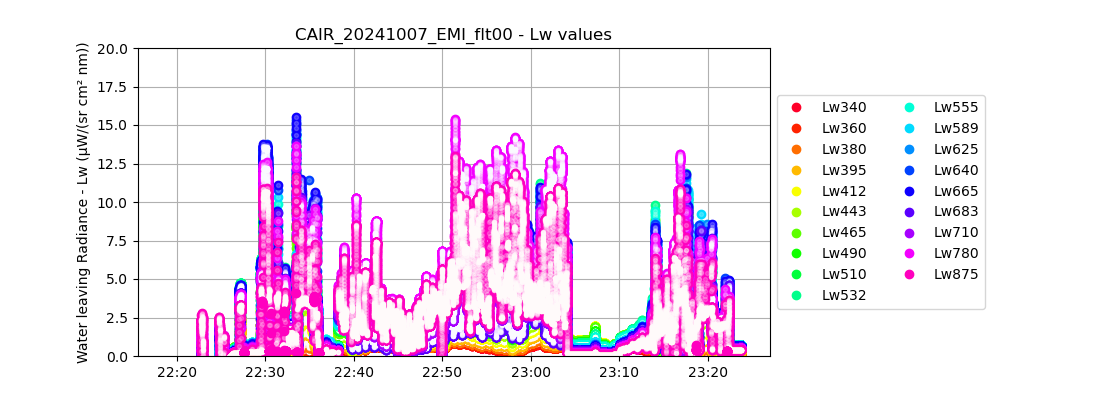

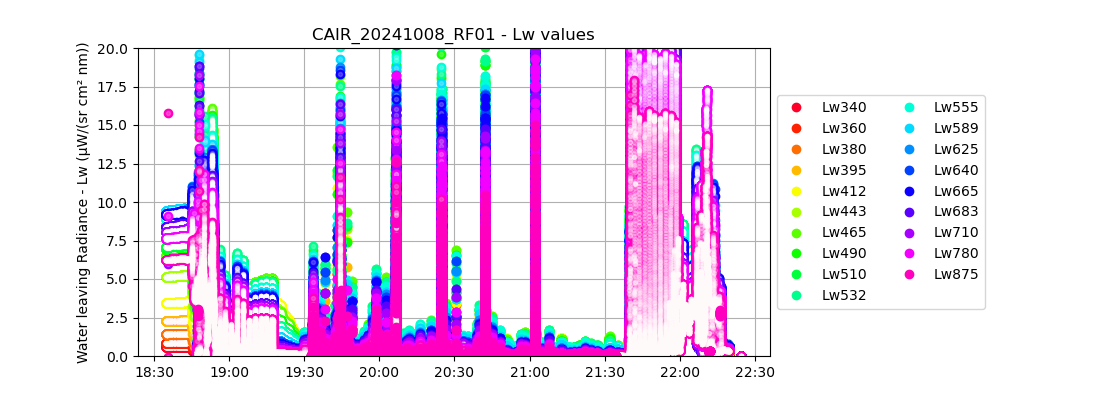

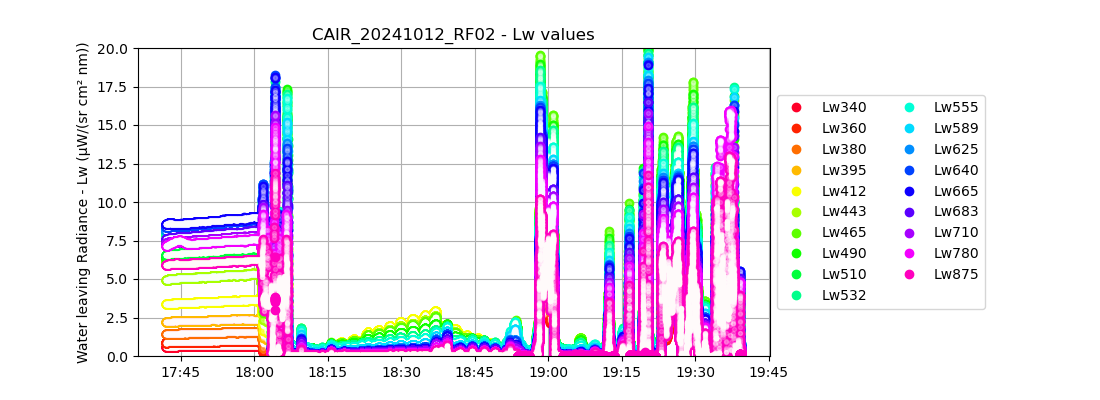

In [267]:
for f in folders:
    fig,ax = plt.subplots(1,figsize=(11,4))
    ax.set_prop_cycle('color', [plt.get_cmap('gist_rainbow')(k) for k in np.linspace(0,1,len(Lt_names))])
    flt = data[f]['filter']
    for v in Lw_names:
        p = plt.plot(data[f].index,data[f][v],'o')
        plt.plot(data[f].index,data[f][v],'o',color='white',alpha=0.2,markersize=2.9)
        plt.plot(data[f].index[flt],data[f][v][flt],'o',label=v,color=p[0].get_color())
    plt.legend(frameon=True,ncols=2,loc='center left', bbox_to_anchor=(1, 0.5))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
    plt.title(f+' - Lw values')
    plt.ylabel('Water leaving Radiance - Lw '+Lt_unit)
    plt.grid()
    plt.subplots_adjust(right=0.7)
    plt.ylim([0,20])